# Project Management Course - Applied AI Solutions Development

The dataset we will be using is from the Government of Canada website https://open.canada.ca/data/en/dataset/0e1e57aa-e664-41b5-a69f-d814d4407d62.  The dataset is 
an indexed time series of the Toronto Stock Exchange closing prices.  We will be building 3 forecasting models for comparison.  A SARIMAX (Seasonal 
AutoRegressive Moving Averages) model, Facebook's Neural Prophet, and a custom LSTM model.

Importing necessary libraries

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import os

# Data Exploration

In [2]:
# Importing our dataset to take a first look
df = pd.read_csv("10100125.csv")
df.head()

,REF_DATE,GEO,DGUID,Toronto Stock Exchange Statistics,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1956-01,Canada,2016A000011124,Standard and Poor's/Toronto Stock Exchange Com...,"Index, 2000=1000",176,units,0,v122620,1.3,525.63,NaN,NaN,NaN,2
1,1956-01,Canada,2016A000011124,"Toronto Stock Exchange, oil and gas, closing q...","Index, 2000=1000",176,units,0,v122621,1.4,485.02,NaN,NaN,t,2
2,1956-01,Canada,2016A000011124,"Toronto Stock Exchange, metals and minerals, c...","Index, 2000=1000",176,units,0,v122622,1.5,729.73,NaN,NaN,t,2
3,1956-01,Canada,2016A000011124,"Toronto Stock Exchange, utilities, closing quo...","Index, 2000=1000",176,units,0,v122623,1.6,914.11,NaN,NaN,t,2
4,1956-01,Canada,2016A000011124,"Toronto Stock Exchange, paper and forest produ...","Index, 2000=1000",176,units,0,v122624,1.7,1013.23,NaN,NaN,t,2


In [6]:
# The dataset appears to be a monthly record of the TSE's closing price, indexed to the year 2000 (1000 point index).  The TSE is then split into different industry composites,
# for example mining vs forest products.  The UOM_ID, scalar_factor, and secalar_id should be consistent throughout the dataset, this will need to be verified.  

df['REF_DATE'].min(), df['REF_DATE'].max()

# Our dataset appears to cover from Jan 1956 until Dec 2021.

('1956-01', '2021-12')

In [8]:
# Checking the GEO feature to confirm all values say Canada, and this column is only provided for convenience when combining datasets
df['GEO'].value_counts()

# Confirmed, this feature will need to be dropped

Canada    11134
Name: GEO, dtype: int64

In [10]:
# This code, after some research, is a geographic identifier.  It should be consistent and can be dropped
df['DGUID'].value_counts()

2016A000011124    11134
Name: DGUID, dtype: int64

In [11]:
# Next we come to the description of the index provided.  We are only interested in the composite of the entire market.  The industry indexes are likely to have changed
# over the years.

df['Toronto Stock Exchange Statistics'].value_counts()

# As we can see the opening and closing prices weren't tracked for the first 150 time periods.

Standard and Poor's/Toronto Stock Exchange Composite Index, close                          792
Toronto Stock Exchange, stock dividend yields (composite), closing quotations              729
Toronto Stock Exchange, price earnings ratio, closing quotations                           729
Toronto Stock Exchange, oil and gas, closing quotations                                    570
Toronto Stock Exchange, metals and minerals, closing quotations                            570
Toronto Stock Exchange, utilities, closing quotations                                      570
Toronto Stock Exchange, paper and forest products, closing quotations                      570
Toronto Stock Exchange, merchandising, closing quotations                                  570
Toronto Stock Exchange, financial services, closing quotations                             570
Toronto Stock Exchange, gold and silver, closing quotations                                570
Standard and Poor's/Toronto Stock Exchange Composi

In [19]:
# We need to confirm that our intended subset spans the entire period we're looking for, and there's no name change
closing_subset = df.loc[df['Toronto Stock Exchange Statistics'] == 'Standard and Poor\'s/Toronto Stock Exchange Composite Index, close']

print(closing_subset.head())
print(closing_subset.tail())

# Here we confirm that our intended category spans the entirety of Jan 1956 to Dec 2021.

   REF_DATE     GEO           DGUID  \
0   1956-01  Canada  2016A000011124   
10  1956-02  Canada  2016A000011124   
20  1956-03  Canada  2016A000011124   
30  1956-04  Canada  2016A000011124   
40  1956-05  Canada  2016A000011124   

                    Toronto Stock Exchange Statistics               UOM  \
0   Standard and Poor's/Toronto Stock Exchange Com...  Index, 2000=1000   
10  Standard and Poor's/Toronto Stock Exchange Com...  Index, 2000=1000   
20  Standard and Poor's/Toronto Stock Exchange Com...  Index, 2000=1000   
30  Standard and Poor's/Toronto Stock Exchange Com...  Index, 2000=1000   
40  Standard and Poor's/Toronto Stock Exchange Com...  Index, 2000=1000   

    UOM_ID SCALAR_FACTOR  SCALAR_ID   VECTOR  COORDINATE   VALUE STATUS  \
0      176        units           0  v122620         1.3  525.63    NaN   
10     176        units           0  v122620         1.3  545.15    NaN   
20     176        units           0  v122620         1.3  588.91    NaN   
30     176    

In [21]:
# Here we confirm that UOM is standardized throughout our dataset
closing_subset['UOM'].value_counts()

Index, 2000=1000    792
Name: UOM, dtype: int64

In [22]:
# Unnecessary feature
closing_subset['UOM_ID'].value_counts()

176    792
Name: UOM_ID, dtype: int64

In [24]:
# Unnecessary feature
closing_subset['VECTOR'].value_counts()

v122620    792
Name: VECTOR, dtype: int64

In [25]:
# We can now safely assume that all other values are standardized and unnecessary for our model, we only need a subset of the closing TSE values and the time period

# Data Cleaning

In [3]:
# Here we create a subset to extract only data on the TSE records
df = df.loc[df['Toronto Stock Exchange Statistics'] == 'Standard and Poor\'s/Toronto Stock Exchange Composite Index, close']

In [4]:
# Then we can extract only the data and value columns
df = df[['REF_DATE', 'VALUE']].reset_index(drop=True)

# Data Exploration and Decomposition

In [5]:
# It's time to do some data exploration.  In order to prepare our data, we need to set the index in a datatime format, and have one column of values
Y = df['VALUE']
date = df['REF_DATE']
date = np.array(date,dtype=np.datetime64)
Series = pd.DataFrame(Y)
Series = Series.set_index(date, drop=True)
Series.head()

,VALUE
1956-01-01,525.63
1956-02-01,545.15
1956-03-01,588.91
1956-04-01,583.61
1956-05-01,560.09


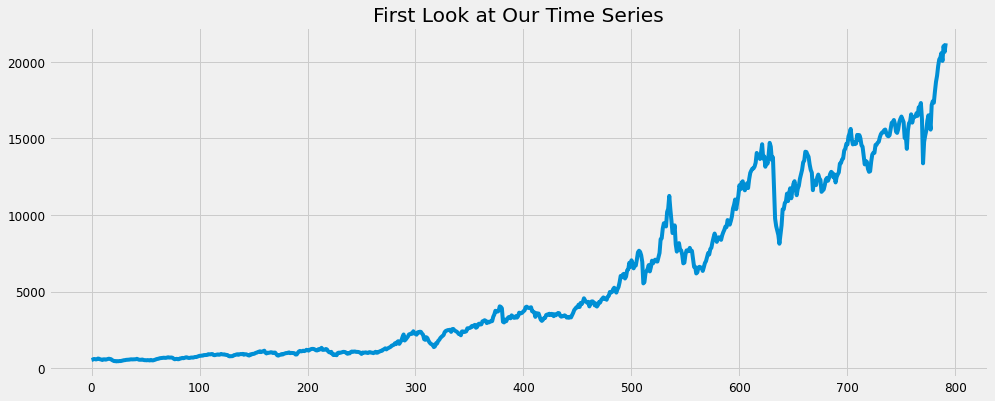

In [6]:
# Here we plot our data to get a first look
Y.plot(figsize=(15, 6))
plt.title('First Look at Our Time Series')
plt.show()

Time series data can exhibit a variety of patterns, and it is often helpful to split a time series into several components, each representing an underlying pattern category.
If we assume an additive decomposition, then we can write yt=St+Tt+Rt,where yt is the data, St is the seasonal component, Tt is the trend-cycle component, and Rt is 
the remainder component, all at period t. Alternatively, a multiplicative decomposition would be written as yt=St×Tt×Rt.
The additive decomposition is the most appropriate if the magnitude of the seasonal fluctuations, or the variation around the trend-cycle, does not vary 
with the level of the time series. When the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be proportional to the level
of the time series, then a multiplicative decomposition is more appropriate. 

The first graph represents the raw data of our model.  The 3 subsequent graphs represent the decomposed components of our raw data, that can be added together
to reconstruct the data shown in the top panel  The first graph is the raw data, the 2nd is the trend, 3rd is the seasonality component, and the 4th represents the 
residuals.

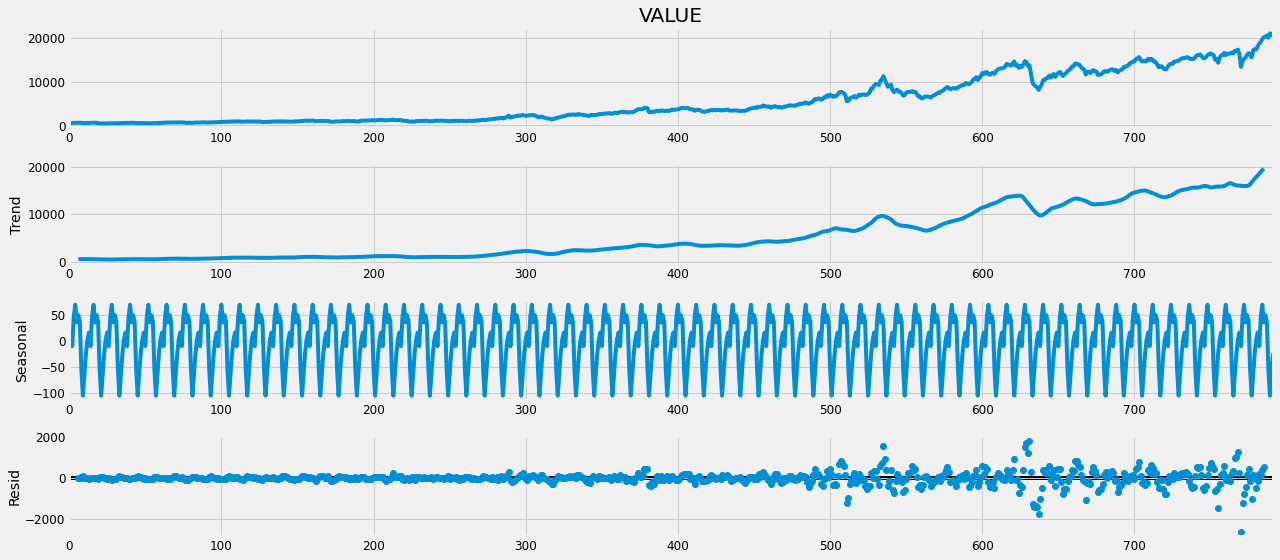

In [9]:
# First we will check an additive decomposition with a period of 12, or 1 year
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(Y, model='additive', period=12)
fig = decomposition.plot()
plt.show()

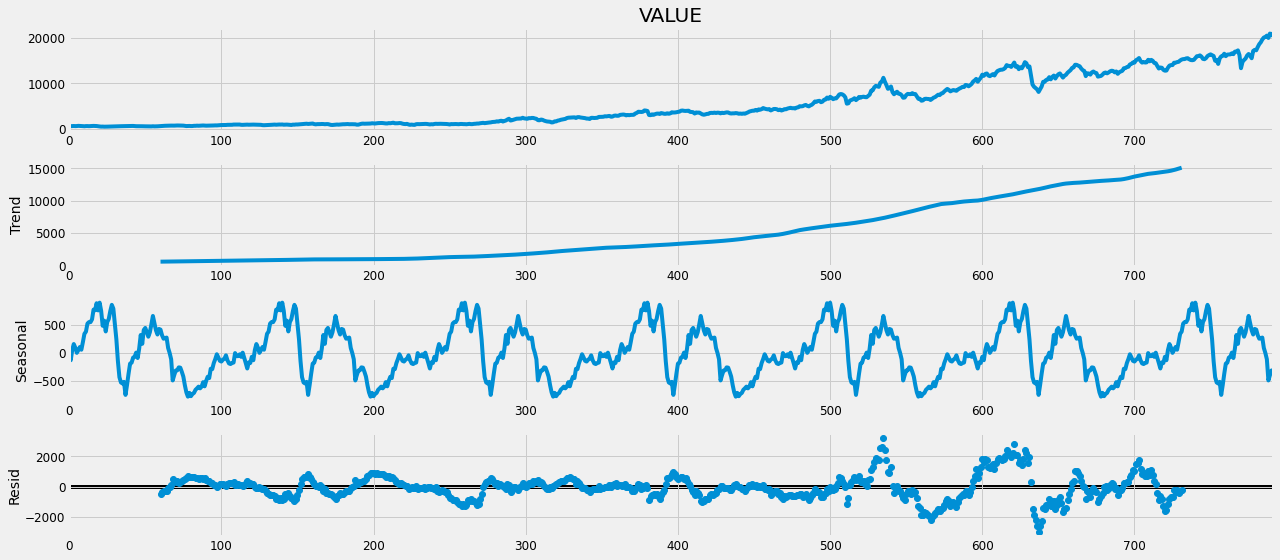

In [151]:
# Here we check seasonality over 120 periods, or 10 years
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(Y, model='additive', period=120)
fig = decomposition.plot()
plt.show()

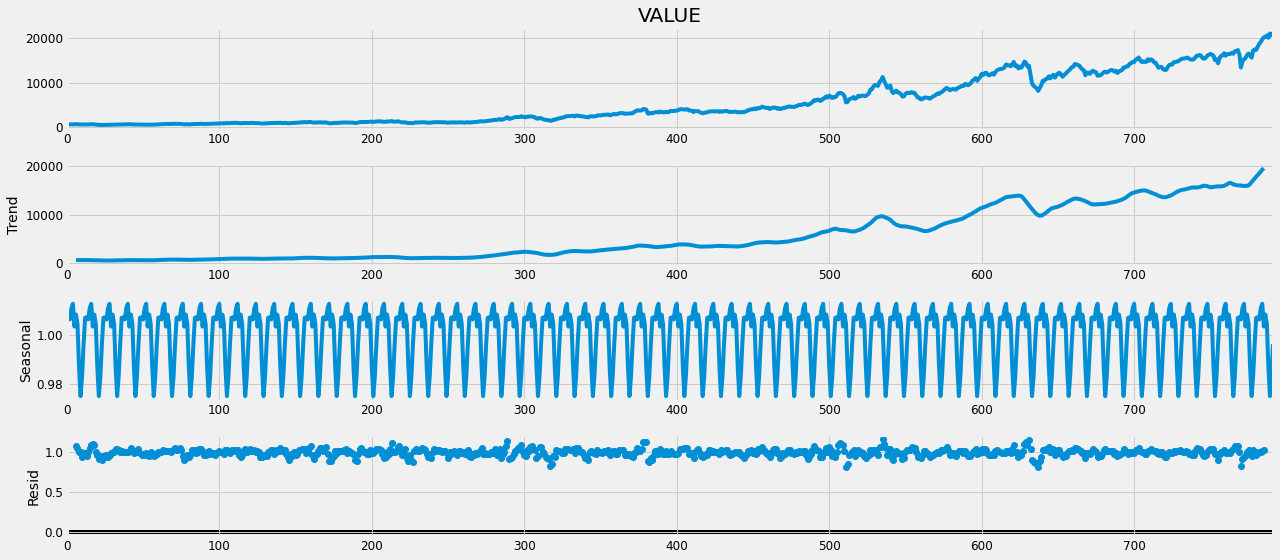

In [162]:
# Multiplicative model over 12 periods, or 1 year
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(Y, model='multiplicative', period=12)
fig = decomposition.plot()
plt.show()

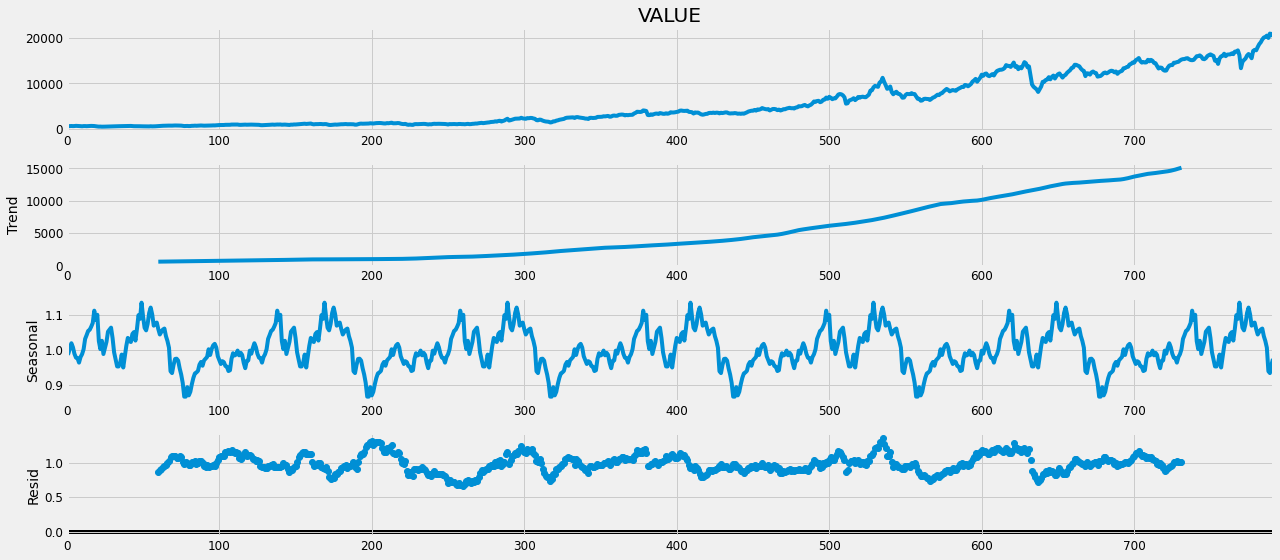

In [166]:
#Multiplicative decomposition over a period of 120 periods, or 10 years
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(Y, model='multiplicative', period=120)
fig = decomposition.plot()
plt.show()

As we can see, a multiplicative model results is lower residuals.  Residuals are useful in checking whether a model has adequately captured the information in the data.
In addition, residuals should be uncorrelated, as we can see in our 120 period multiplicative model, the residuals appear to follow the trend of the seasonality chart,
meaning it has not captured the data well.

This will be useful information for hyperparameter tuning our models.

Non-linear models can be difficult for models.  We can see if transforming our data would be beneficial.

### Log Transform of our Signal

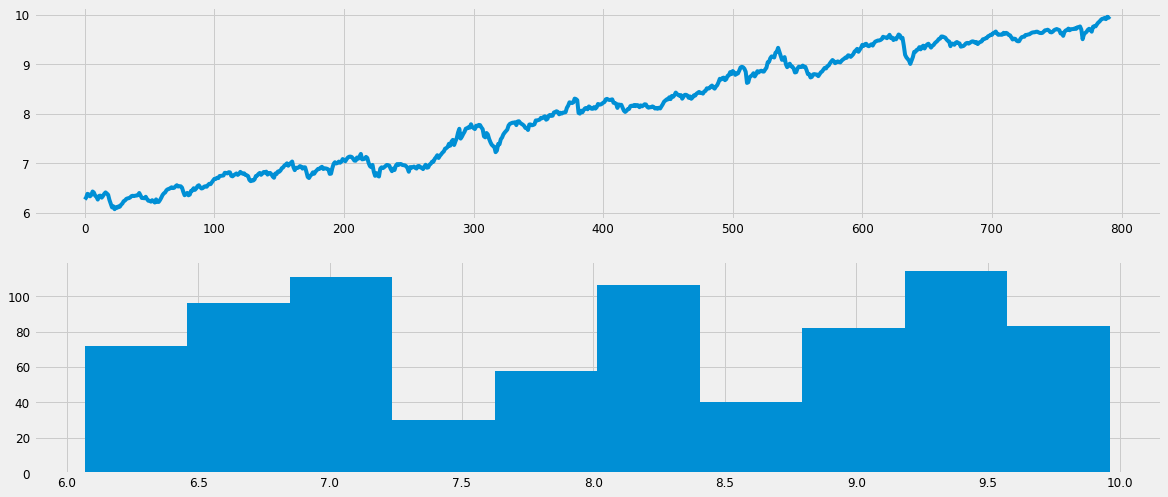

In [10]:
from matplotlib import pyplot
from math import exp
from numpy import log

y = log(Y)
pyplot.figure(1)
# line plot
pyplot.subplot(211)
pyplot.plot(y)
# histogram
pyplot.subplot(212)
pyplot.hist(y)
pyplot.show()

Log transforming our signal turns the growth of our trendline from an exponential growth line to a linear growth line.  This will help our model performance

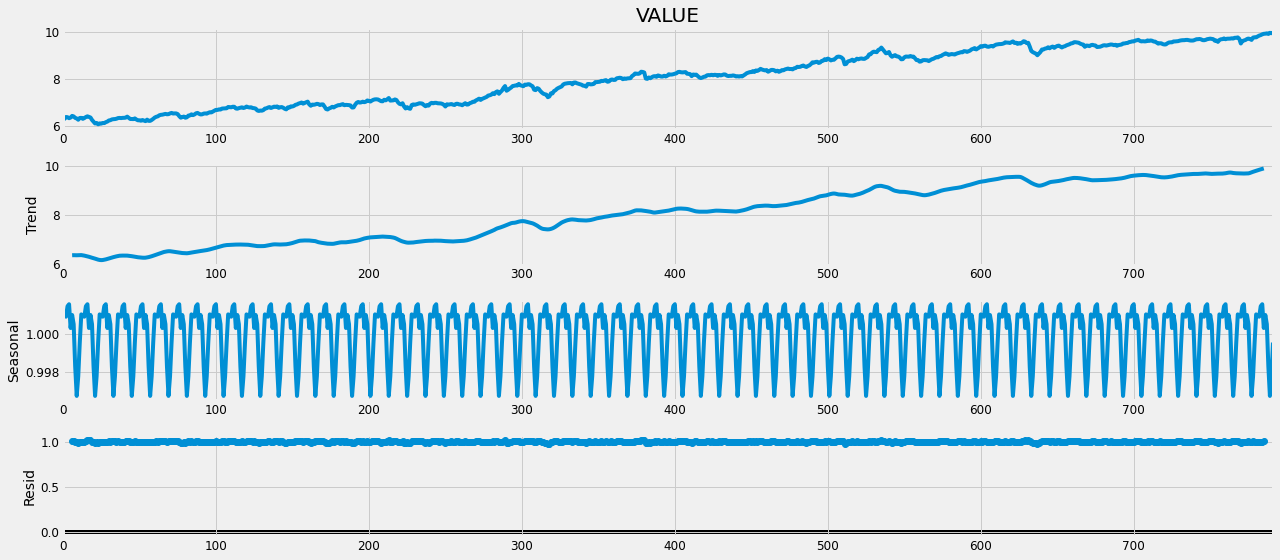

In [11]:
# Now if we do a 12 month decomposition the residuals appear as white noise (or random)
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative', period=12)
fig = decomposition.plot()
plt.show()

# Forecast Models

### Neural Prophet

Neural Prophet is facebook's improvement upon their old forecasting package called Prophet.  The aim is to combine traditional forecasting techniques with neural network
models, in order to provide more readability than neural networks.

In [12]:
from neuralprophet import NeuralProphet
import pandas as pd

In [13]:
# For Neural Prophet we only need 2 columns, time in a column called ds and Y for the values
neurodata = df[['REF_DATE', 'VALUE']]
neurodata.rename(columns = {'REF_DATE':'ds', 'VALUE':'y'}, inplace=True)
print(neurodata.head())
print(neurodata.tail())

        ds       y
0  1956-01  525.63
1  1956-02  545.15
2  1956-03  588.91
3  1956-04  583.61
4  1956-05  560.09
          ds         y
787  2021-08  20582.94
788  2021-09  20070.30
789  2021-10  21037.10
790  2021-11  20660.00
791  2021-12  21223.00


In [14]:
# Applying our log transform
neurodata['y'] = np.log(neurodata['y'])

In [15]:
# The model has been built to be easy to deploy with only a couple lines of code.  Hyperparameter tuning is done with variables within the model, and takes some getting
# used to.  Here we have chosen 30 change points (which is a lot) because of the far reaching length of our time series, 1 hidden layer, and multiplicative since we're 
# dealing with economic data

m = NeuralProphet(seasonality_mode='multiplicative',  
                  num_hidden_layers=1, 
                  n_changepoints=30,
                  changepoints_range=1)
metrics = m.fit(neurodata, 
                freq="M")
forecast = m.predict(neurodata)

INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 191


  0%|          | 0/245 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.79E-02, min: 1.70E+00


  0%|          | 0/245 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.79E-02, min: 1.56E+00


  0%|          | 0/245 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.79E-02, min: 1.56E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.79E-02
Epoch[191/191]: 100%|██████████| 191/191 [00:09<00:00, 20.27it/s, SmoothL1Loss=0.000295, MAE=0.0667, RMSE=0.0849, RegLoss=0]


In [16]:
# We've built our model, now we need to forecast a period of 12 months to see how it performs
future = m.make_future_dataframe(neurodata, periods=12)
forecast = m.predict(future)

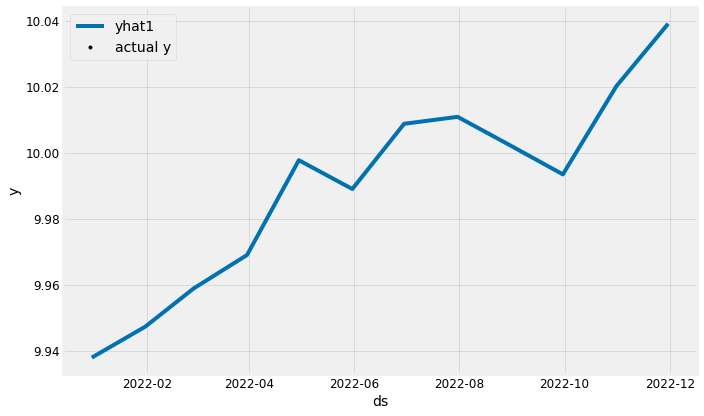

In [17]:
# First look at neuroprophet's predictions
forecasts_plot = m.plot(forecast)

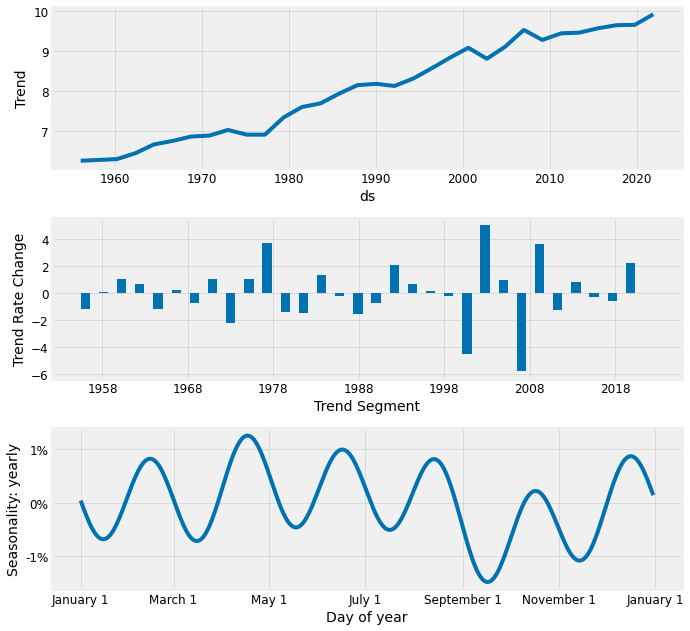

In [18]:
fig_param = m.plot_parameters()

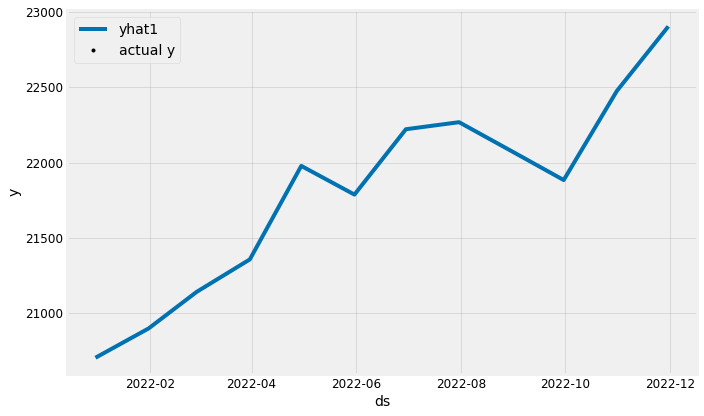

In [19]:
# This is our current signal, but our signal has been transformed.  We will need to reverse log transform our data back to get valid numbers

forecast['yhat1'] = np.exp(forecast['yhat1'])
forecasts_plot = m.plot(forecast)